In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
import torch.optim as optim
from torch.distributions import Distribution
from torch.distributions.dirichlet import Dirichlet
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from typing import Tuple, List, Callable

from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
from torchvision import utils as vutils
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output

import wandb
import os 
get_cwd = os.getcwd()
root_dir = os.path.dirname(get_cwd)
#os.environ['WANDB_NOTEBOOK_NAME'] = 'Coupling_mnist_plots.ipynb'
import sys
#sys.path.append(r'c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN')
sys.path.append(root_dir)
print("root_dir", root_dir)
sys.path.append(os.path.join(root_dir, 'postnet'))

from postnet.metrics import accuracy, brier_score, confidence, ood_detection, entropy
from postnet.Learning_scheduler import GradualWarmupScheduler, train, init_weights
from postnet.PosteriorNetwork_class import NormalisingFlow, AffineCouplingLayer, Conditioner, PosteriorNetwork
from postnet.LoadDataset_class import LoadDataset, load_Moons, load_MNIST, load_CIFAR


# set seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

############ HYPERPARAMETERS ################

#lr = 0.00005
training_lr = 3e-4 # start of training (end of warmup ) #Note: High LR create NaNs and Inf 
start_lr = 1e-9 # start of warmup
min_lr = 1e-7 # during cosine annealing
num_epochs = 2 # flere epochs maybe 12000
warmup_steps= 500
validation_every_steps = 50 # is actually every epoch in training loop!!
#validation_every_epochs = 1
weight_decay = 5e-7  # L2 regularization strength to prevent overfitting in Adam or AdamW 
batch_size = 64
early_stop_delta = 0.001 #in procent this is 0.1% 
early_stop_patience = 20 # so after 20 validations without improvement, stop training
split = lambda x: x.chunk(2, dim=-1)
reg = 1e-6 # entropy regularisation
annealing_interval = 40 # Every 10 epochs, anneal LR (warm restart)

num_classes = 10
latent_dim = 6 # Change to 4 or 6    # the encoder outputs 2D latent space
data_dim = 6 # the encoder outputs n-D latent space
in_dim= data_dim // 2 # since we split the data
out_dim= data_dim // 2
num_params = 2 # s and t
num_hidden = 3 # number of hidden layers
hidden_dim = 64 # neurons in hidden layers
num_flows = 6 # number of coupling flow layers

dataset_name = 'MNIST'
ood_dataset_names = ['Fashion-MNIST', 'KMNIST']
subset_percentage = 1 # So use all data
split_ratios = [0.6, 0.8] # hardcoded in LoadDataset_class to 60% training, 20% validation, 20% test

wandb.init(
    project='Normalising-Flow-DNN',
    config={
        'architecture': 'PostNet',
        'dataset': dataset_name,
        'training_lr': training_lr,
        'start_lr': start_lr,
        'min_lr': min_lr,
        'num_epochs': num_epochs,
        'warmup_steps': warmup_steps,
        'validation_every_steps': validation_every_steps,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'early_stop_delta': early_stop_delta,
        'early_stop_patience': early_stop_patience,
        'reg': reg,
        'annealing_interval': annealing_interval,
        'num_classes': num_classes,
        'latent_dim': latent_dim,
        'num_params': num_params,
        'num_hidden': num_hidden,
        'hidden_dim': hidden_dim,
        'num_flows': num_flows,
    }
    #name='run_name',
    #tags=['experiment1', ''],
    #notes='Trying out a new architecture',
    #dir='/path/to/log/files',
    ##entity='my_team',
    #group='experiment_group',
    #job_type='train'
)

############ LOAD MNIST DATASET ################
loaders, N_counts, set_lengths, ood_dataset_loaders, N_ood = load_MNIST(batch_size, subset_percentage=None, split_ratios=[0.6,0.8], seed=seed)

print("N train:", N_counts['train'])
print("N val:", N_counts['val'])
print("N test:", N_counts['test'])

print("Train set length:", set_lengths['train'])
print("Validation set length:", set_lengths['val'])
print("Test set length:", set_lengths['test'])

############# INSTANTIATE MODEL ##################
flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split, data_dim) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device)) #maybe move out of loop?

    flow_model = NormalisingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)

postnet_model = PosteriorNetwork(latent_dim, flow_models, N_counts['train'], num_classes, reg, dataset_name).to(device) 
optimiser = optim.AdamW(postnet_model.parameters(), lr=training_lr, weight_decay=weight_decay)

warmup_scheduler = GradualWarmupScheduler(optimiser, warmup_steps=warmup_steps, start_lr=start_lr, end_lr=training_lr)
training_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=annealing_interval, eta_min=min_lr, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=5, gamma=0.1)
#torch_lr_scheduler = ExponentialLR(optimizer=default_optimizer, gamma=0.98)


root_dir c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN
cuda


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fenriswulven (dtu_projects). Use `wandb login --relogin` to force relogin


c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN
N train: tensor([3556., 4000., 3545., 3673., 3483., 3311., 3604., 3781., 3486., 3561.],
       dtype=torch.float64)
N val: tensor([1195., 1355., 1197., 1293., 1220., 1044., 1107., 1226., 1161., 1202.],
       dtype=torch.float64)
N test: tensor([1172., 1387., 1216., 1165., 1139., 1066., 1207., 1258., 1204., 1186.],
       dtype=torch.float64)
Train set length: 36000
Validation set length: 12000
Test set length: 12000
total_steps_per_epoch 563
Warmup epochs: 1


'\ndef train(model, optimiser, train_loader, val_loader, num_epochs, validation_every_steps, early_stop_delta, \n          early_stop_patience, warmup_scheduler, training_scheduler, warmup_steps, N_counts, set_lengths, device):\n    model.train()\n    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []\n    all_train_losses = []\n    best_val_loss = float("Inf")\n    step = 0 # how many batches we have trained on (each batch is 64 samples) #9000 training samples / 64 batch size = 140 batches per epoch\n    counter = 0 # for early stopping \n    early_stopping = False\n    total_steps_per_epoch = len(train_loader)  # Total batches (steps) per epoch\n    warmup_epochs = math.ceil(warmup_steps / total_steps_per_epoch)  # Total warmup epochs\n    wandb.watch(model, log="all")\n\n    for epoch in range(num_epochs): #epoch is one forward pass through the entire training set\n        train_losses_batches, train_accuracies_batches = [], []\n        #batches_counter = 0\

In [2]:
train_losses, val_losses, train_accuracies, val_accuracies, all_train_losses = train(postnet_model, optimiser, loaders['train'], loaders['val'], 
                                                num_epochs, validation_every_steps, early_stop_delta, early_stop_patience, warmup_scheduler, 
                                                training_scheduler, warmup_steps, N_counts, set_lengths, device)

Step: 50, Epoch: 1	Train Loss: 163.9207, Val Loss: 168.0848, Train Accuracy: 0.1313, Val Accuracy: 0.1511
Model saved
Step: 100, Epoch: 1	Train Loss: 162.5934, Val Loss: 166.4561, Train Accuracy: 0.1730, Val Accuracy: 0.2742
Model saved
Step: 150, Epoch: 1	Train Loss: 157.6804, Val Loss: 152.4038, Train Accuracy: 0.2189, Val Accuracy: 0.3867
Model saved


KeyboardInterrupt: 

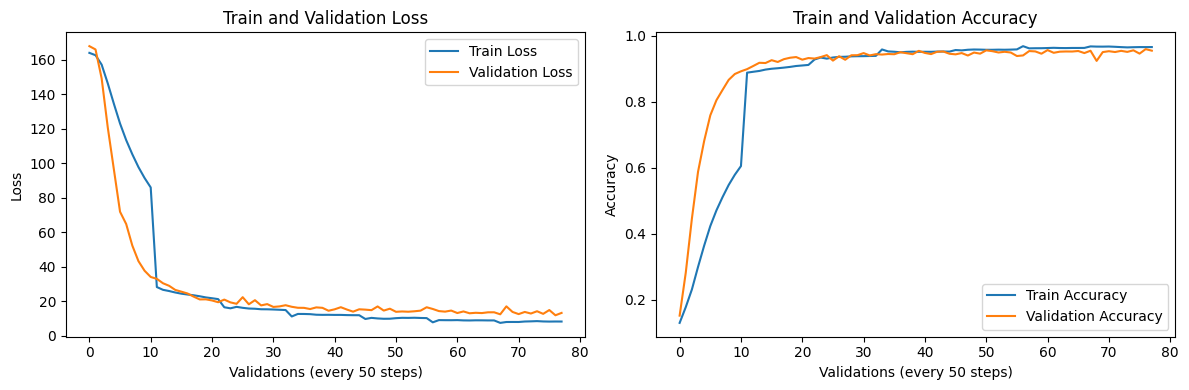

<Figure size 640x480 with 0 Axes>

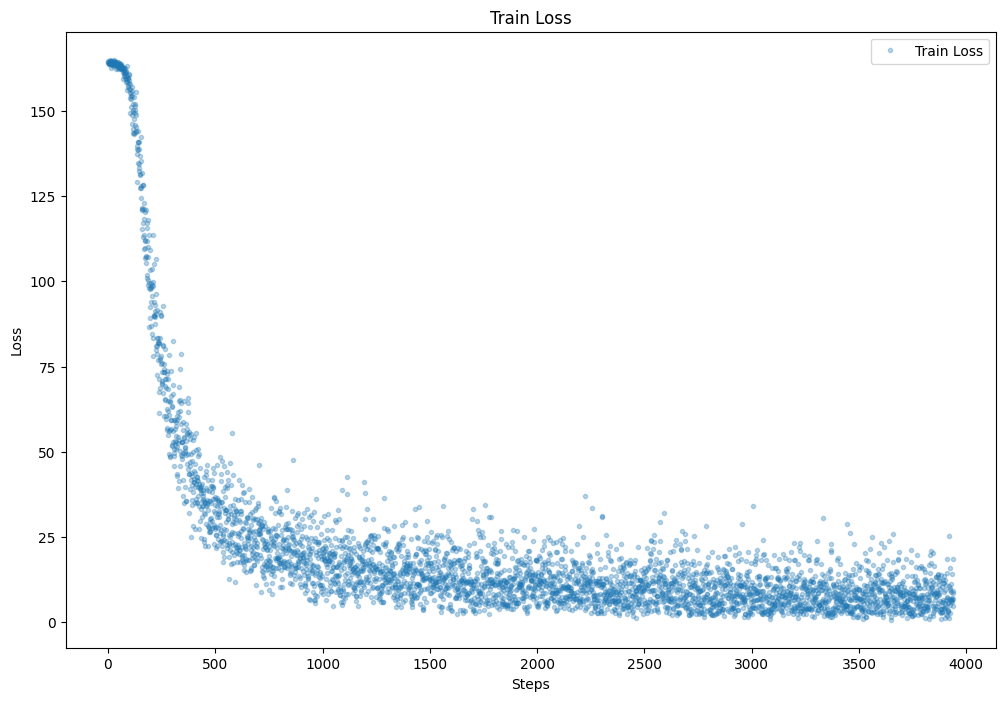

<Figure size 640x480 with 0 Axes>

In [5]:
########### PLOTS ################
# Plot loss of training and validation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Validations (every 50 steps)')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()

# Plot accuracies of training and validation
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Validations (every 50 steps)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train and Validation Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()
plt.savefig(f'{root_dir}/plots_mnist/training_loss_acc.png', bbox_inches='tight')

# plot all_train_losses
plt.figure(figsize=(12,8))
plt.plot(all_train_losses,  '.',label='Train Loss', alpha=0.3)
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()
plt.savefig(f'{root_dir}/plots_mnist/training_all_losses_acc.png', bbox_inches='tight')


In [7]:
###### TESTING #####
subset_percentage = None
ood_subset_percentage = None
device = torch.device("cpu")
dataset_name = 'MNIST'
checkpoint = torch.load('best_model_mnist_friday2.pth')

get_cwd = os.getcwd()
print(get_cwd)
root_dir = os.path.dirname(get_cwd)

#test_loader = dataset.get_data_loaders(batch_size=batch_size, split_ratios=split_ratios)
#N_test = dataset.get_class_counts(dataset.test_indices)

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ]) # makes MNIST pixels [-1, 1]
# dataset = LoadDataset(dataset_name, './data', train=False, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=seed)
# mnist_loader = dataset.get_full_loader(batch_size=batch_size)
# N_mnist

flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split, data_dim) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device)) #maybe move out of loop?

    flow_model = NormalisingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)
testing_model = PosteriorNetwork(latent_dim, flow_models, N_counts['test'], num_classes, reg, dataset_name).to(device) 
device = torch.device("cpu")

ood_dataset_names = ['FashionMNIST', 'KMNIST']
ood_dataset_loaders = {}
N_ood = {}
for ood_dataset_name in ood_dataset_names: 
    ood_dataset = LoadDataset(ood_dataset_name, './data', train=False, transform=transform, subset_percentage=ood_subset_percentage, split_ratios=split_ratios, seed=seed)
    ood_dataset_loaders[ood_dataset_name] = ood_dataset.get_full_loader(batch_size=batch_size)
    N_ood[ood_dataset_name] = ood_dataset.get_class_counts(ood_dataset.indices)


print("N_ood:", N_ood)

print("Observations in MNIST test_loader:", len(test_loader.dataset))
print("Observations in FashionMNIST test_loader:", len(ood_dataset_loaders['FashionMNIST'].dataset))
print("Observations in KMNIST test_loader:", len(ood_dataset_loaders['KMNIST'].dataset))

def compute_all_y_alphas(model, loader, device, N):
    all_y_test = []
    all_alphas = []
    with torch.no_grad():
        for X_test, y_test in loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Forward pass
            alpha = model(X_test, N)
            all_y_test.append(y_test.cpu())
            all_alphas.append(alpha.cpu())
    
    all_y_test = torch.cat(all_y_test)
    all_alphas = torch.cat(all_alphas)

    return all_y_test, all_alphas

def evaluate_model(model, test_loader, ood_dataset_loaders, checkpoint, device):
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    #N_test = test_loader.dataset.get_class_counts() 
    all_y_test, all_alphas = compute_all_y_alphas(model, test_loader, device, N_test)

    test_metrics = {}
    test_metrics['accuracy'] = accuracy(y=all_y_test, alpha=all_alphas)
    test_metrics['brier_score'] = brier_score(y=all_y_test, alpha=all_alphas)
    test_metrics['confidence_APR_aleatoric'] = confidence(y=all_y_test, alpha=all_alphas, score_type='APR', uncertainty_type='aleatoric')
    test_metrics['confidence_APR_epistemic'] = confidence(y=all_y_test, alpha=all_alphas, score_type='APR', uncertainty_type='epistemic')
    
    # Compute anomaly detection metrics for Fashion-MNIST and KMNIST in ood_dataset_loaders
    for ood_dataset_name, ood_dataset_loader in ood_dataset_loaders.items():
        _, ood_all_alphas = compute_all_y_alphas(model, ood_dataset_loader, device, N_ood[ood_dataset_name])
        test_metrics[f'ood_detection_aleatoric_{ood_dataset_name}'] = ood_detection(alpha=all_alphas, ood_alpha=ood_all_alphas, score_type='APR', uncertainty_type='aleatoric')
        test_metrics[f'ood_detection_epistemic_{ood_dataset_name}'] = ood_detection(alpha=all_alphas, ood_alpha=ood_all_alphas, score_type='APR', uncertainty_type='epistemic') 

    return test_metrics
    
#test_metrics = evaluate_model(testing_model, mnist_loader, ood_dataset_loaders, checkpoint, device)
test_metrics = evaluate_model(testing_model, test_loader, ood_dataset_loaders, checkpoint, device)
for key, value in test_metrics.items():
    print(f'{key}: {value}')

c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN\notebooks
N_ood: {'FashionMNIST': tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       dtype=torch.float64), 'KMNIST': tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       dtype=torch.float64)}
Observations in MNIST test_loader: 60000
Observations in FashionMNIST test_loader: 10000
Observations in KMNIST test_loader: 10000
accuracy: 0.36025
brier_score: 0.8294979929924011
confidence_APR_aleatoric: 0.6393892955782134
confidence_APR_epistemic: 0.5567733322299251
ood_detection_aleatoric_FashionMNIST: 0.6639730811357312
ood_detection_epistemic_FashionMNIST: 0.451536918225953
ood_detection_aleatoric_KMNIST: 0.6406175410914341
ood_detection_epistemic_KMNIST: 0.46229955630766784
